<a href="https://colab.research.google.com/github/bsong75/brendensong.github.io/blob/gh-pages/9_h_Pytorch_CIFAR_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1UmL9Swki0CIGfyXiHZtSrA51TciiJtQe')

     |████████████████████████████████| 71kB 5.1MB/s 


# Classifying images of everyday objects using a neural network

The ability to try many different neural network architectures to address a problem is what makes deep learning really powerful, especially compared to shallow learning techniques like linear regression, logistic regression etc. 

In this assignment, you will:

1. Explore the CIFAR10 dataset: https://www.cs.toronto.edu/~kriz/cifar.html
2. Set up a training pipeline to train a neural network on a GPU
2. Experiment with different network architectures & hyperparameters

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end. Try to experiment with different network structures and hypeparameters to get the lowest loss.

You might find these notebooks useful for reference, as you work through this notebook:

- https://jovian.ml/aakashns/04-feedforward-nn
- https://jovian.ml/aakashns/fashion-feedforward-minimal

In [5]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet

In [6]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [7]:
# Project name used for jovian.commit
project_name = '03-cifar10-feedforward'

## Exploring the CIFAR10 dataset

In [8]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

Extracting data/cifar-10-python.tar.gz to data/


**Q: How many images does the training dataset contain?**

In [9]:
dataset_size=len(dataset)
dataset_size

50000

**Q: How many images does the training dataset contain?**

In [10]:
test_dataset_size = len(test_dataset)
test_dataset_size

10000

**Q: How many output classes does the dataset contain? Can you list them?**

Hint: Use `dataset.classes`

In [11]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [12]:
num_classes = len(classes)
num_classes

10

**Q: What is the shape of an image tensor from the dataset?**

In [13]:
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

Note that this dataset consists of 3-channel color images (RGB). Let us look at a sample image from the dataset. `matplotlib` expects channels to be the last dimension of the image tensors (whereas in PyTorch they are the first dimension), so we'll the `.permute` tensor method to shift channels to the last dimension. Let's also print the label for the image.

Label (numeric): 6
Label (textual): frog


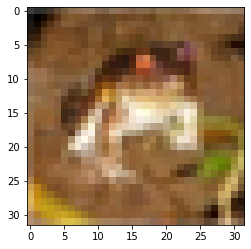

In [14]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

**(Optional) Q: Can you determine the number of images belonging to each class?**

Hint: Loop through the dataset.

In [15]:
airplane=0
automobile=0
bird=0
cat=0
deer=0
dog=0
frog=0
horse=0
ship=0
truck=0

for i in range(50000):
    img, label=dataset[i]
    if classes[label]=='airplane':
        airplane=airplane+1
    if classes[label]=='automobile':
        automobile+=1
    if classes[label]=='bird':
        bird+=1
    if classes[label]=='cat':
        cat+=1
    if classes[label]=='deer':
        deer+=1
    if classes[label]=='dog':
        dog+=1
    if classes[label]=='frog':
        frog+=1
    if classes[label]=='horse':
        horse+=1
    if classes[label]=='ship':
        ship+=1
    if classes[label]=='truck':
        truck+=1



In [16]:
print(airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck)

5000 5000 5000 5000 5000 5000 5000 5000 5000 5000


Let's save our work to Jovian, before continuing.

In [17]:
!pip install jovian --upgrade --quiet

In [18]:
import jovian

In [19]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/bsong75/03-cifar10-feedforward


'https://jovian.ai/bsong75/03-cifar10-feedforward'

## Preparing the data for training

We'll use a validation set with 5000 images (10% of the dataset). To ensure we get the same validation set each time, we'll set PyTorch's random number generator to a seed value of 43.

In [20]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size

Let's use the `random_split` method to create the training & validation sets

In [21]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

We can now create data loaders to load the data in batches.

In [22]:
batch_size=128

In [23]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

Let's visualize a batch of data using the `make_grid` helper function from Torchvision.

images.shape: torch.Size([128, 3, 32, 32])


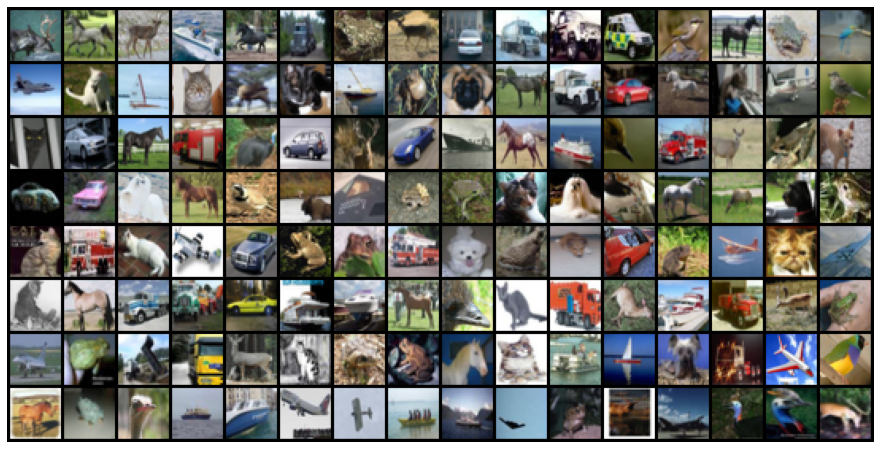

In [24]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

Can you label all the images by looking at them? Trying to label a random sample of the data manually is a good way to estimate the difficulty of the problem, and identify errors in labeling, if any.

## Base Model class & Training on GPU

Let's create a base model class, which contains everything except the model architecture i.e. it wil not contain the `__init__` and `__forward__` methods. We will later extend this class to try out different architectures. In fact, you can extend this model to solve any image classification problem.

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [26]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

We can also use the exact same training loop as before. I hope you're starting to see the benefits of refactoring our code into reusable functions.

In [27]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Finally, let's also define some utilities for moving out data & labels to the GPU, if one is available.

In [28]:
torch.cuda.is_available()

True

In [29]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [30]:
device = get_default_device()
device

device(type='cuda')

In [31]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Let us also define a couple of helper functions for plotting the losses & accuracies.

In [32]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [33]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

Let's move our data loaders to the appropriate device.

In [34]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Training the model

We will make several attempts at training the model. Each time, try a different architecture and a different set of learning rates. Here are some ideas to try:
- Increase or decrease the number of hidden layers
- Increase of decrease the size of each hidden layer
- Try different activation functions
- Try training for different number of epochs
- Try different learning rates in every epoch

What's the highest validation accuracy you can get to? **Can you get to 50% accuracy? What about 60%?**

In [54]:
input_size = 3*32*32
hidden_size = 64
output_size = 10


**Q: Extend the `ImageClassificationBase` class to complete the model definition.**

Hint: Define the `__init__` and `forward` methods.

In [55]:
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        #hidden layer
        self.linear1=nn.Linear(input_size, hidden_size)
        #output layer
        self.linear2=nn.Linear(hidden_size, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors from 1x28x28 to 1x784
        out = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(out)
        #Apply activation function; get negative values into 0
        out=F.relu(out)
        #Get preditions using output layer
        out= self.linear2(out)
        return out

You can now instantiate the model, and move it the appropriate device.

In [56]:
model = to_device(CIFAR10Model(), device)

In [57]:
for t in model.parameters():
    print(t.shape)

torch.Size([64, 3072])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


Before you train the model, it's a good idea to check the validation loss & accuracy with the initial set of weights.

In [58]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.10410156100988388, 'val_loss': 2.311762571334839}]

**Q: Train the model using the `fit` function to reduce the validation loss & improve accuracy.**

Leverage the interactive nature of Jupyter to train the model in multiple phases, adjusting the no. of epochs & learning rate each time based on the result of the previous training phase.

In [59]:
history += fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 2.2688, val_acc: 0.1561
Epoch [1], val_loss: 2.2346, val_acc: 0.2023
Epoch [2], val_loss: 2.1968, val_acc: 0.2117
Epoch [3], val_loss: 2.1595, val_acc: 0.2330
Epoch [4], val_loss: 2.1262, val_acc: 0.2408


In [60]:
history += fit(20, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 2.0964, val_acc: 0.2511
Epoch [1], val_loss: 2.0702, val_acc: 0.2618
Epoch [2], val_loss: 2.0484, val_acc: 0.2708
Epoch [3], val_loss: 2.0286, val_acc: 0.2824
Epoch [4], val_loss: 2.0113, val_acc: 0.2927
Epoch [5], val_loss: 1.9965, val_acc: 0.2971
Epoch [6], val_loss: 1.9835, val_acc: 0.3013
Epoch [7], val_loss: 1.9711, val_acc: 0.3084
Epoch [8], val_loss: 1.9602, val_acc: 0.3171
Epoch [9], val_loss: 1.9490, val_acc: 0.3185
Epoch [10], val_loss: 1.9399, val_acc: 0.3261
Epoch [11], val_loss: 1.9318, val_acc: 0.3269
Epoch [12], val_loss: 1.9242, val_acc: 0.3269
Epoch [13], val_loss: 1.9160, val_acc: 0.3329
Epoch [14], val_loss: 1.9090, val_acc: 0.3353
Epoch [15], val_loss: 1.9025, val_acc: 0.3402
Epoch [16], val_loss: 1.8965, val_acc: 0.3437
Epoch [17], val_loss: 1.8905, val_acc: 0.3446
Epoch [18], val_loss: 1.8852, val_acc: 0.3476
Epoch [19], val_loss: 1.8801, val_acc: 0.3483


In [61]:
history += fit(20, 0.0008, model, train_loader, val_loader)

Epoch [0], val_loss: 1.8755, val_acc: 0.3508
Epoch [1], val_loss: 1.8724, val_acc: 0.3505
Epoch [2], val_loss: 1.8684, val_acc: 0.3540
Epoch [3], val_loss: 1.8646, val_acc: 0.3531
Epoch [4], val_loss: 1.8609, val_acc: 0.3584
Epoch [5], val_loss: 1.8577, val_acc: 0.3608
Epoch [6], val_loss: 1.8537, val_acc: 0.3616
Epoch [7], val_loss: 1.8507, val_acc: 0.3649
Epoch [8], val_loss: 1.8485, val_acc: 0.3622
Epoch [9], val_loss: 1.8446, val_acc: 0.3652
Epoch [10], val_loss: 1.8421, val_acc: 0.3674
Epoch [11], val_loss: 1.8391, val_acc: 0.3670
Epoch [12], val_loss: 1.8362, val_acc: 0.3700
Epoch [13], val_loss: 1.8340, val_acc: 0.3711
Epoch [14], val_loss: 1.8303, val_acc: 0.3732
Epoch [15], val_loss: 1.8274, val_acc: 0.3749
Epoch [16], val_loss: 1.8249, val_acc: 0.3733
Epoch [17], val_loss: 1.8230, val_acc: 0.3744
Epoch [18], val_loss: 1.8200, val_acc: 0.3783
Epoch [19], val_loss: 1.8175, val_acc: 0.3760


In [62]:
history += fit(20, 0.0005, model, train_loader, val_loader)

Epoch [0], val_loss: 1.8162, val_acc: 0.3771
Epoch [1], val_loss: 1.8146, val_acc: 0.3785
Epoch [2], val_loss: 1.8133, val_acc: 0.3790
Epoch [3], val_loss: 1.8125, val_acc: 0.3770
Epoch [4], val_loss: 1.8107, val_acc: 0.3781
Epoch [5], val_loss: 1.8094, val_acc: 0.3770
Epoch [6], val_loss: 1.8077, val_acc: 0.3803
Epoch [7], val_loss: 1.8065, val_acc: 0.3838
Epoch [8], val_loss: 1.8049, val_acc: 0.3799
Epoch [9], val_loss: 1.8037, val_acc: 0.3805
Epoch [10], val_loss: 1.8024, val_acc: 0.3801
Epoch [11], val_loss: 1.8009, val_acc: 0.3815
Epoch [12], val_loss: 1.8000, val_acc: 0.3811
Epoch [13], val_loss: 1.7991, val_acc: 0.3801
Epoch [14], val_loss: 1.7981, val_acc: 0.3838
Epoch [15], val_loss: 1.7961, val_acc: 0.3842
Epoch [16], val_loss: 1.7949, val_acc: 0.3852
Epoch [17], val_loss: 1.7943, val_acc: 0.3814
Epoch [18], val_loss: 1.7928, val_acc: 0.3825
Epoch [19], val_loss: 1.7914, val_acc: 0.3850


In [63]:
history += fit(20, 0.0002, model, train_loader, val_loader)

Epoch [0], val_loss: 1.7907, val_acc: 0.3837
Epoch [1], val_loss: 1.7902, val_acc: 0.3846
Epoch [2], val_loss: 1.7897, val_acc: 0.3854
Epoch [3], val_loss: 1.7892, val_acc: 0.3855
Epoch [4], val_loss: 1.7888, val_acc: 0.3865
Epoch [5], val_loss: 1.7883, val_acc: 0.3857
Epoch [6], val_loss: 1.7879, val_acc: 0.3842
Epoch [7], val_loss: 1.7874, val_acc: 0.3875
Epoch [8], val_loss: 1.7870, val_acc: 0.3852
Epoch [9], val_loss: 1.7866, val_acc: 0.3883
Epoch [10], val_loss: 1.7861, val_acc: 0.3848
Epoch [11], val_loss: 1.7855, val_acc: 0.3860
Epoch [12], val_loss: 1.7852, val_acc: 0.3879
Epoch [13], val_loss: 1.7849, val_acc: 0.3873
Epoch [14], val_loss: 1.7843, val_acc: 0.3883
Epoch [15], val_loss: 1.7837, val_acc: 0.3883
Epoch [16], val_loss: 1.7833, val_acc: 0.3872
Epoch [17], val_loss: 1.7828, val_acc: 0.3869
Epoch [18], val_loss: 1.7823, val_acc: 0.3877
Epoch [19], val_loss: 1.7819, val_acc: 0.3883


In [64]:
history += fit(20, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.7817, val_acc: 0.3883
Epoch [1], val_loss: 1.7815, val_acc: 0.3883
Epoch [2], val_loss: 1.7812, val_acc: 0.3873
Epoch [3], val_loss: 1.7809, val_acc: 0.3885
Epoch [4], val_loss: 1.7809, val_acc: 0.3879
Epoch [5], val_loss: 1.7808, val_acc: 0.3883
Epoch [6], val_loss: 1.7805, val_acc: 0.3885
Epoch [7], val_loss: 1.7802, val_acc: 0.3879
Epoch [8], val_loss: 1.7800, val_acc: 0.3879
Epoch [9], val_loss: 1.7797, val_acc: 0.3877
Epoch [10], val_loss: 1.7796, val_acc: 0.3881
Epoch [11], val_loss: 1.7793, val_acc: 0.3885
Epoch [12], val_loss: 1.7791, val_acc: 0.3881
Epoch [13], val_loss: 1.7789, val_acc: 0.3879
Epoch [14], val_loss: 1.7787, val_acc: 0.3890
Epoch [15], val_loss: 1.7784, val_acc: 0.3885
Epoch [16], val_loss: 1.7782, val_acc: 0.3883
Epoch [17], val_loss: 1.7780, val_acc: 0.3879
Epoch [18], val_loss: 1.7778, val_acc: 0.3877
Epoch [19], val_loss: 1.7776, val_acc: 0.3889


Plot the losses and the accuracies to check if you're starting to hit the limits of how well your model can perform on this dataset. You can train some more if you can see the scope for further improvement.

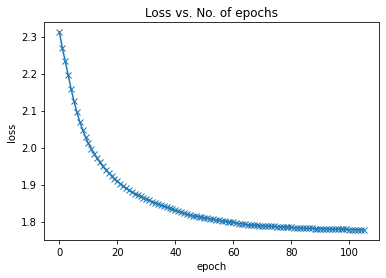

In [65]:
plot_losses(history)

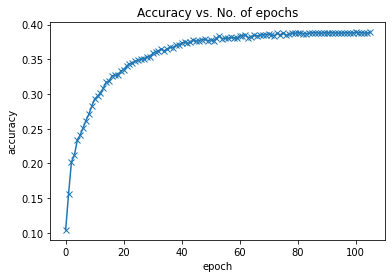

In [66]:
plot_accuracies(history)

Finally, evaluate the model on the test dataset report its final performance.

In [67]:
evaluate(model, test_loader)

{'val_acc': 0.3818359375, 'val_loss': 1.7579818964004517}

Are you happy with the accuracy? Record your results by completing the section below, then you can come back and try a different architecture & hyperparameters.

## Recoding your results

As your perform multiple experiments, it's important to record the results in a systematic fashion, so that you can review them later and identify the best approaches that you might want to reproduce or build upon later. 

**Q: Describe the model's architecture with a short summary.**

E.g. `"3 layers (16,32,10)"` (16, 32 and 10 represent output sizes of each layer)

In [69]:
arch = (32, 64, 10)

**Q: Provide the list of learning rates used while training.**

In [68]:
lrs = [0.001, 0.0008, 0.0005,  0.0002, 0.0001]

**Q: Provide the list of no. of epochs used while training.**

In [70]:
epochs = [5, 20]

**Q: What were the final test accuracy & test loss?**

In [71]:
test_acc = .388
test_loss = 1.777

Finally, let's save the trained model weights to disk, so we can use this model later.

In [72]:
torch.save(model.state_dict(), 'cifar10-feedforward.pth')

The `jovian` library provides some utility functions to keep your work organized. With every version of your notebok, you can attach some hyperparameters and metrics from your experiment.

In [73]:
# Clear previously recorded hyperparams & metrics
jovian.reset()

In [74]:
jovian.log_hyperparams(arch=arch, 
                       lrs=lrs, 
                       epochs=epochs)

[jovian] Hyperparams logged.


In [75]:
jovian.log_metrics(test_loss=test_loss, test_acc=test_acc)

[jovian] Metrics logged.


Finally, we can commit the notebook to Jovian, attaching the hypeparameters, metrics and the trained model weights.

In [76]:
jovian.commit(project=project_name, outputs=['cifar10-feedforward.pth'], environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/bsong75/03-cifar10-feedforward


'https://jovian.ai/bsong75/03-cifar10-feedforward'

Once committed, you can find the recorded metrics & hyperprameters in the "Records" tab on Jovian. You can find the saved model weights in the "Files" tab.

## Continued experimentation

Now go back up to the **"Training the model"** section, and try another network architecture with a different set of hyperparameters. As you try different experiments, you will start to build an undestanding of how the different architectures & hyperparameters affect the final result. Don't worry if you can't get to very high accuracy, we'll make some fundamental changes to our model in the next lecture.

Once you have tried multiple experiments, you can compare your results using the **"Compare"** button on Jovian.

![compare-example](https://i.imgur.com/ltdYnSN.png)

## (Optional) Write a blog post

Writing a blog post is the best way to further improve your understanding of deep learning & model training, because it forces you to articulate your thoughts clearly. Here'are some ideas for a blog post:
- Report the results given by different architectures on the CIFAR10 dataset
- Apply this training pipeline to a different dataset (it doesn't have to be images, or a classification problem) 
- Improve upon your model from Assignment 2 using a feedfoward neural network, and write a sequel to your previous blog post
- Share some Strategies for picking good hyperparameters for deep learning
- Present a summary of the different steps involved in training a deep learning model with PyTorch
- Implement the same model using a different deep learning library e.g. Keras ( https://keras.io/ ), and present a comparision.
